In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

train_generator = datagen.flow_from_directory(
    '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

num_classes = train_generator.num_classes
class_names = list(train_generator.class_indices.keys())

2025-04-17 12:32:18.937834: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744893139.135386      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744893139.197009      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 29632 images belonging to 4 classes.
Found 12698 images belonging to 4 classes.


In [3]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    alpha=1.0
)

Replace the last layers with:

    Global Average Pooling (to flatten features).

    Dense(1024, ReLU).

    Dense(512, ReLU).

    Dense(num_classes, Softmax).

In [5]:
import tensorflow as tf

def create_model(num_classes):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model


In [6]:

print("Creating model...")
model = create_model(num_classes=4)
model.summary()
for layer in model.layers:
    print(f"Layer: {layer.name} | Trainable: {layer.trainable} | Params: {layer.count_params()}")

Creating model...


I0000 00:00:1744893168.072122      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,096,580 (15.63 MB)

 Trainable params: 4,062,468 (15.50 MB)

 Non-trainable params: 34,112 (133.25 KB)

Layer: mobilenetv2_1.00_224 | Trainable: True | Params: 2257984
Layer: global_average_pooling2d | Trainable: True | Params: 0
Layer: dense | Trainable: True | Params: 1311744
Layer: dense_1 | Trainable: True | Params: 524800
Layer: dense_2 | Trainable: True | Params: 2052


In [ ]:
def apply_strategy(model, strategy):
    base_model = model.layers[0]  # MobileNetV2 backbone

    if strategy == "2conv+fc":
        conv_layers = [l for l in base_model.layers if 'conv' in l.name]
        for layer in base_model.layers:
            layer.trainable = False
        for layer in conv_layers[-2:]:
            layer.trainable = True  # last 2 conv layers
    
    elif strategy == "1conv+fc":
        conv_layers = [l for l in base_model.layers if 'conv' in l.name]
        for layer in base_model.layers:
            layer.trainable = False
        conv_layers[-1].trainable = True  # last conv layer
    
    elif strategy == "fc_only":
        base_model.trainable = False

    else:
        raise ValueError("Unknown strategy. Use: fc_only, 1conv+fc, or 2conv+fc.")

In [13]:
import time

def train_model(model, train_ds, val_ds, epochs=20, batch_size=64, lr=0.001):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    start_time = time.time()
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        batch_size=batch_size
    )
    
    end_time = time.time()
    training_time = end_time - start_time
    
    return history, training_time


In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def evaluate_model(model, val_generator, class_names):
    # Predict all validation data at once
    preds = model.predict(val_generator, verbose=0)

    # Get true labels from generator
    y_true = val_generator.classes  # ⚠ Only works if generator was built with labels

    # Convert predictions to label indices
    y_pred = np.argmax(preds, axis=1)

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    return y_true, y_pred


In [15]:
import matplotlib.pyplot as plt

def plot_curves(history):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


Running strategy: fc_only
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744893182.884344     104 service.cc:148] XLA service 0x7fbba4004050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744893182.885030     104 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744893183.820682     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/463 ━━━━━━━━━━━━━━━━━━━━ 1:58:27 15s/step - accuracy: 0.3125 - loss: 1.4920

I0000 00:00:1744893187.955493     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


463/463 ━━━━━━━━━━━━━━━━━━━━ 310s 637ms/step - accuracy: 0.6755 - loss: 0.8426 - val_accuracy: 0.8502 - val_loss: 0.3940
Epoch 2/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 130s 278ms/step - accuracy: 0.7590 - loss: 0.6059 - val_accuracy: 0.8541 - val_loss: 0.3888
Epoch 3/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 127s 273ms/step - accuracy: 0.7824 - loss: 0.5495 - val_accuracy: 0.8552 - val_loss: 0.3978
Epoch 4/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 133s 285ms/step - accuracy: 0.7908 - loss: 0.5231 - val_accuracy: 0.8654 - val_loss: 0.3904
Epoch 5/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 133s 285ms/step - accuracy: 0.7960 - loss: 0.5126 - val_accuracy: 0.8561 - val_loss: 0.3916
Epoch 6/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 130s 278ms/step - accuracy: 0.7987 - loss: 0.5096 - val_accuracy: 0.8679 - val_loss: 0.3740
Epoch 7/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 131s 280ms/step - accuracy: 0.8096 - loss: 0.4839 - val_accuracy: 0.8736 - val_loss: 0.4081
Epoch 8/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 131s 280ms/step - accuracy: 0.8124 - loss: 0.46

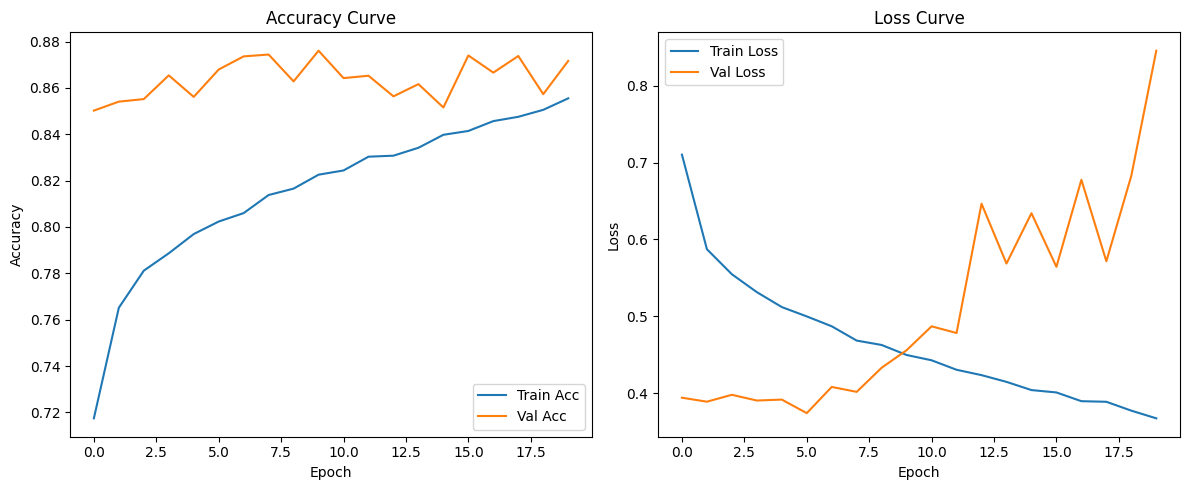

Training time for fc_only: 2804.62 seconds

Running strategy: 1conv+fc
Epoch 1/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 146s 289ms/step - accuracy: 0.6615 - loss: 0.8852 - val_accuracy: 0.4639 - val_loss: 1.4901
Epoch 2/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 133s 284ms/step - accuracy: 0.7683 - loss: 0.5825 - val_accuracy: 0.8487 - val_loss: 0.4121
Epoch 3/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 135s 289ms/step - accuracy: 0.7791 - loss: 0.5565 - val_accuracy: 0.8330 - val_loss: 0.4629
Epoch 4/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 132s 283ms/step - accuracy: 0.7899 - loss: 0.5275 - val_accuracy: 0.8571 - val_loss: 0.4263
Epoch 5/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 133s 285ms/step - accuracy: 0.8017 - loss: 0.4986 - val_accuracy: 0.8777 - val_loss: 0.3561
Epoch 6/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 133s 285ms/step - accuracy: 0.8039 - loss: 0.4877 - val_accuracy: 0.8519 - val_loss: 0.4264
Epoch 7/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 132s 283ms/step - accuracy: 0.8127 - loss: 0.4685 - val_accuracy: 0.8768 - val_loss: 0.3787
Epoch

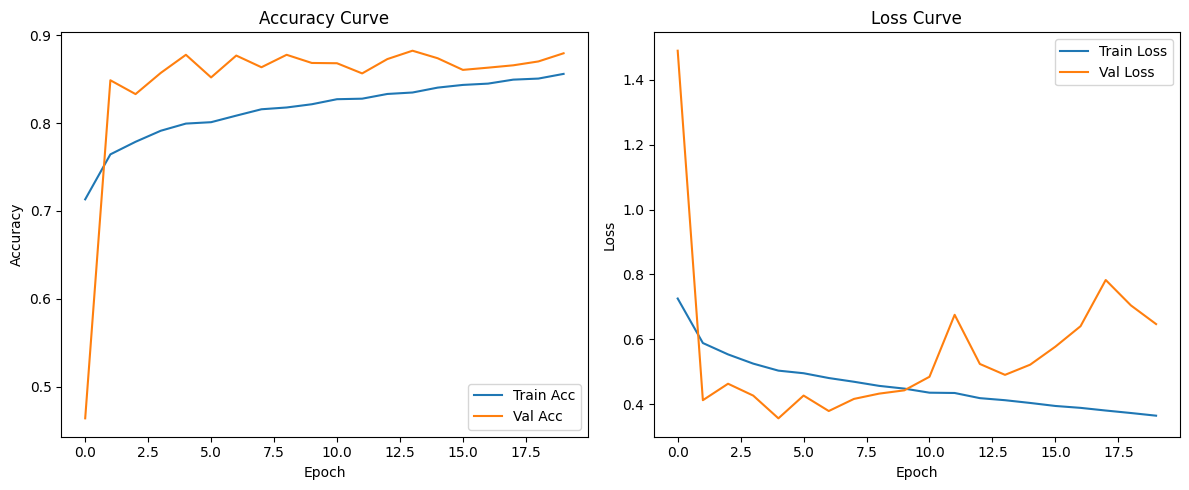

Training time for 1conv+fc: 2702.97 seconds

Running strategy: 2conv+fc
Epoch 1/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 149s 296ms/step - accuracy: 0.6667 - loss: 0.8716 - val_accuracy: 0.2078 - val_loss: 2.8121
Epoch 2/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 133s 285ms/step - accuracy: 0.7621 - loss: 0.5864 - val_accuracy: 0.2111 - val_loss: 2.4104
Epoch 3/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 135s 289ms/step - accuracy: 0.7826 - loss: 0.5443 - val_accuracy: 0.2711 - val_loss: 2.2212
Epoch 4/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 137s 293ms/step - accuracy: 0.7913 - loss: 0.5203 - val_accuracy: 0.2835 - val_loss: 2.9479
Epoch 5/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 135s 289ms/step - accuracy: 0.8037 - loss: 0.4987 - val_accuracy: 0.2785 - val_loss: 3.4057
Epoch 6/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 136s 290ms/step - accuracy: 0.8051 - loss: 0.4847 - val_accuracy: 0.4987 - val_loss: 1.7604
Epoch 7/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 134s 286ms/step - accuracy: 0.8161 - loss: 0.4686 - val_accuracy: 0.4835 - val_loss: 2.1915
Epoc

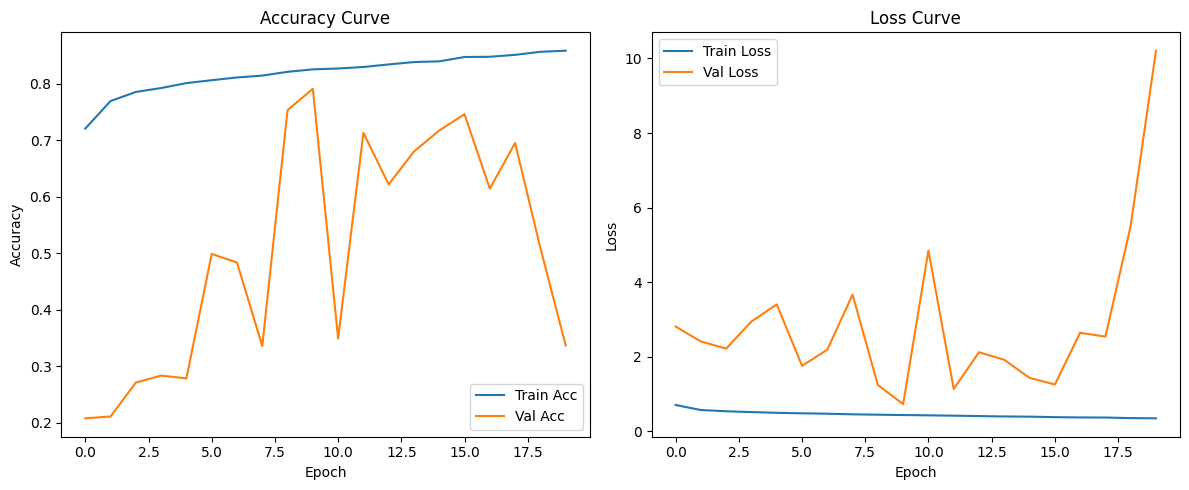

Training time for 2conv+fc: 2723.44 seconds



In [16]:
for strategy in ["fc_only", "1conv+fc", "2conv+fc"]:
    print(f"Running strategy: {strategy}")
    
    model = create_model(num_classes)
    apply_strategy(model, strategy=strategy)
    
    history, training_time = train_model(model, train_generator, val_generator)
    
    y_true, y_pred = evaluate_model(model, val_generator, class_names)
    
    plot_curves(history)
    print(f"Training time for {strategy}: {training_time:.2f} seconds\n")


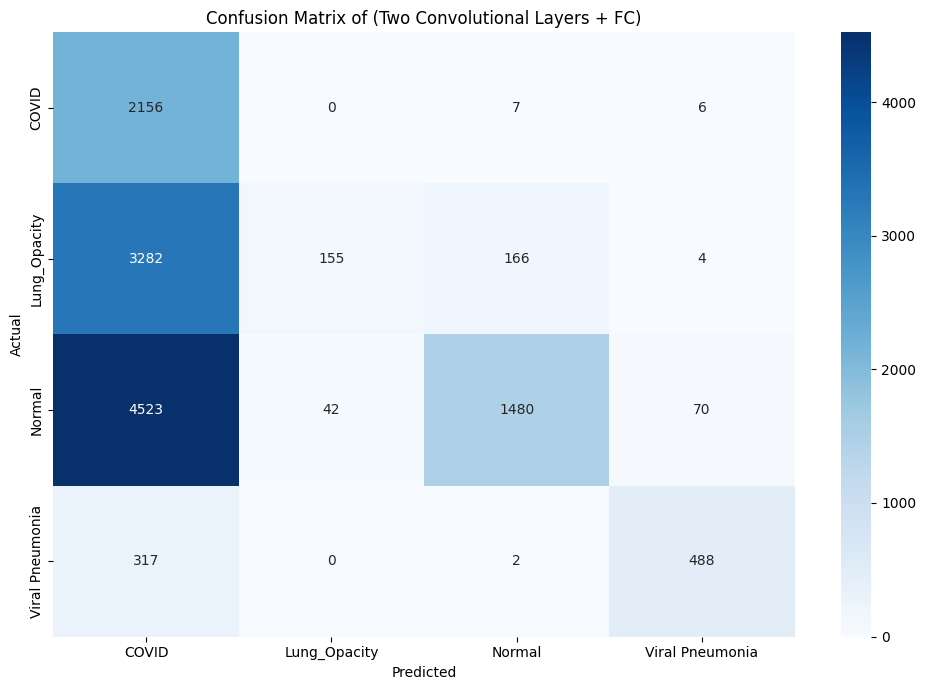

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Construct the confusion matrix from the provided image
conf_matrix = np.array([
    [2156, 0, 7, 6],
    [3282, 155, 166, 4],
    [4523, 42, 1480, 70],
    [317, 0, 2, 488]
])

# Define class labels
class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix of (Two Convolutional Layers + FC)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


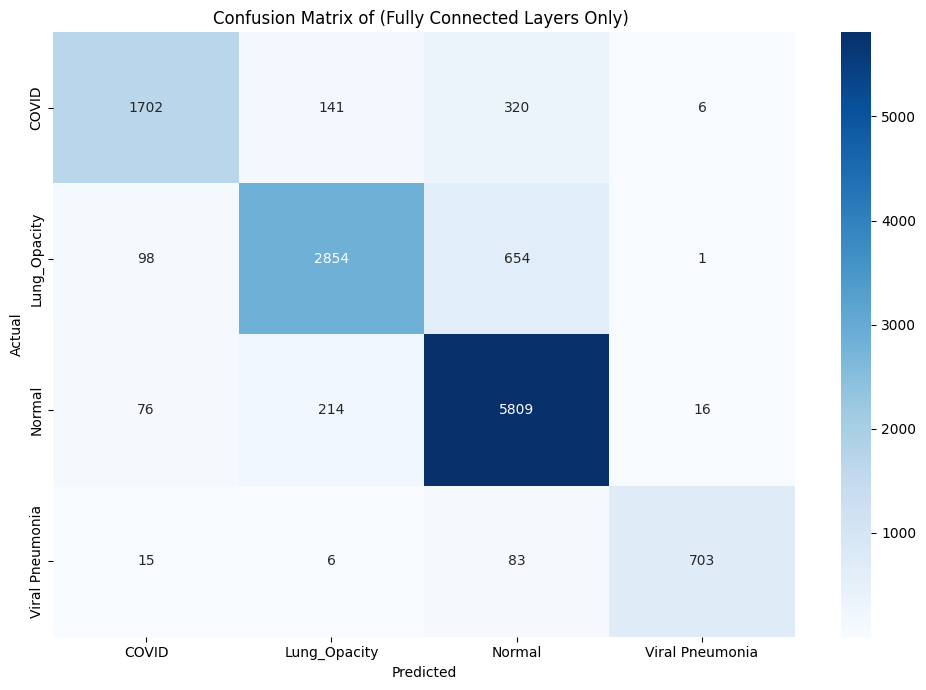

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Construct the confusion matrix from the provided image
conf_matrix = np.array([
    [1702, 141, 320, 6],
    [98, 2854, 654, 1],
    [76, 214, 5809, 16],
    [15, 6, 83, 703]
])

# Define class labels
class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix of (Fully Connected Layers Only) ')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


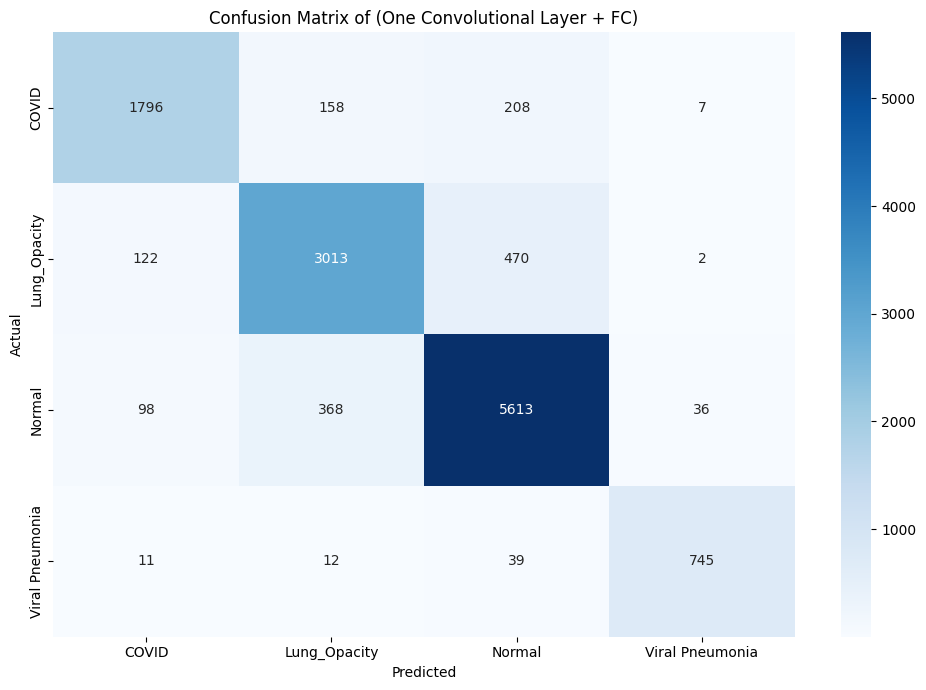

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Construct the confusion matrix from the provided image
conf_matrix = np.array([
    [1796, 158, 208, 7],
    [122, 3013, 470, 2],
    [98, 368, 5613, 36],
    [11, 12, 39, 745]
])

# Define class labels
class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix of (One Convolutional Layer + FC)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()
